In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
from scipy import stats
import matplotlib.pyplot as plt
import pickle
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

In [2]:
# set some default
pd.set_option('display.float_format', str)
sns.set_palette('Spectral')

In [3]:
df = pd.read_pickle('data_Han/Han_df_cleaned')

In [4]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.0,1180,5650,1.0,0,0,2,7,1180,0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,2,7,2170,400,1951,1991.0,98125,47.721,-122.319,1690,7639
2,180000.0,2,1.0,770,10000,1.0,0,0,2,6,770,0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.0,1960,5000,1.0,0,0,4,7,1050,910,1965,0.0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.0,1680,8080,1.0,0,0,2,8,1680,0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [5]:
df.view.value_counts()

0    19485
2      957
3      508
1      330
4      317
Name: view, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  int64  
 7   view           21597 non-null  int8   
 8   condition      21597 non-null  int8   
 9   grade          21597 non-null  int32  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  int32  
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   21597 non-null  float64
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  sqft_living15  21597 non-null  int64  
 18  sqft_l

# ASSUMPTIONS ON KEY FEATURES

 * location
 * living space, especially a good bathroom
 * House condition
 * distance to downtown/office
 * neighborhood

## list of things to explore

***LOCATION***
 * zipcode - area
 * waterfront/view important
 * neiborhood amenities
 * is height important?/flood
 
***LIVING SPACE*** 
 * bigger house sells more?
 * more bedrooms/bathrooms sells more?
 * more floors sells more?
 * space allocations
 * Floor Area Ratio sells more?
 
***HOUSE CONDITION***
* year built & renovated
* Age & condition

***NEIGHBORHOOD***
* amenities, parks, hospitals, etc...
* safety
 
***INVESTMENT***
 * year built
 * view/waterfront
 * flood zone/latitude
 
 
***OVERALL INTUITION***
 * sqrt_living
 * bedrooms/bathrooms
 * view/waterfront
 * zipcode
 * year_built

# EDA LOCATION

In [7]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.0,1180,5650,1.0,0,0,2,7,1180,0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,2,7,2170,400,1951,1991.0,98125,47.721,-122.319,1690,7639
2,180000.0,2,1.0,770,10000,1.0,0,0,2,6,770,0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.0,1960,5000,1.0,0,0,4,7,1050,910,1965,0.0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.0,1680,8080,1.0,0,0,2,8,1680,0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [8]:
df_temp = df.zipcode.value_counts()

### which zipcode has highest average price?

In [9]:
col_selector = ['price','zipcode','sqft_living']
df_loc = df[col_selector]
df_loc.head()

,price,zipcode,sqft_living
0,221900.0,98178,1180
1,538000.0,98125,2570
2,180000.0,98028,770
3,604000.0,98136,1960
4,510000.0,98074,1680


In [10]:
df_loc.shape

(21597, 3)

In [11]:
df_avg_price_zipcode = df_loc.groupby('zipcode').mean().sort_values(by='price')
df_avg_price_zipcode.head()

,price,sqft_living
zipcode,,
98002,234284.0351758794,1627.7437185929648
98168,240328.3717472119,1468.6245353159852
98032,251296.24,1738.048
98001,281194.8698060942,1903.7839335180056
98148,284908.5964912281,1610.5263157894738


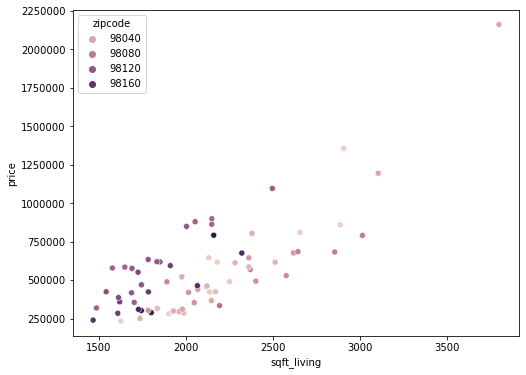

In [16]:
fig,ax = plt.subplots(figsize=(8,6))
sns.scatterplot(hue=df_avg_price_zipcode.index,
                y='price', x='sqft_living',
               data=df_avg_price_zipcode)
ax.ticklabel_format(style='plain');

# for i in range(df_avg_price_zipcode.shape[0]):
#     plt.text(x = df_avg_price_zipcode.sqft_living[i], y = df_avg_price_zipcode.price[i], s = df_avg_price_zipcode.index[i],fontsize=11);

In [17]:
df_avg_price_zipcode

,price,sqft_living
zipcode,,
98002,234284.0351758794,1627.7437185929648
98168,240328.3717472119,1468.6245353159852
98032,251296.24,1738.048
98001,281194.8698060942,1903.7839335180056
98148,284908.5964912281,1610.5263157894738
...,...,...
98102,899607.6730769231,2151.048076923077
98112,1096239.0074349442,2498.7434944237916
98040,1194873.6382978724,3106.8333333333335


In [18]:
pd.cut(df_avg_price_zipcode.price, 4, labels=[1,2,3,4]).value_counts()

1    57
2    11
4     1
3     1
Name: price, dtype: int64

# EDA LIVING SPACE

In [90]:
col_selector = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','sqft_above','sqft_basement']
df_ls = df[col_selector]

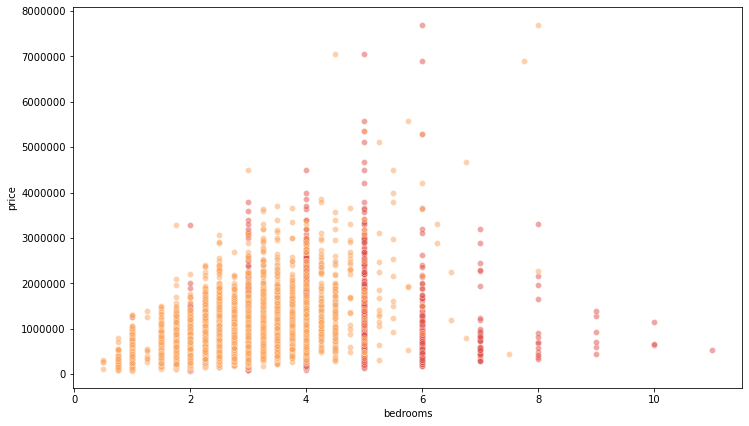

In [91]:
fig,ax = plt.subplots(figsize=(12,7))
sns.scatterplot(x = 'bedrooms', y = 'price', data = df_ls,alpha=0.5)
sns.scatterplot(x = 'bathrooms', y = 'price', data = df_ls,alpha=0.5)
ax.ticklabel_format(style='plain');

In [92]:
df_ls['BR/BTH'] = df_ls['bedrooms']/df_ls['bathrooms']

<ipython-input-92-9e6e56325113>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ls['BR/BTH'] = df_ls['bedrooms']/df_ls['bathrooms']


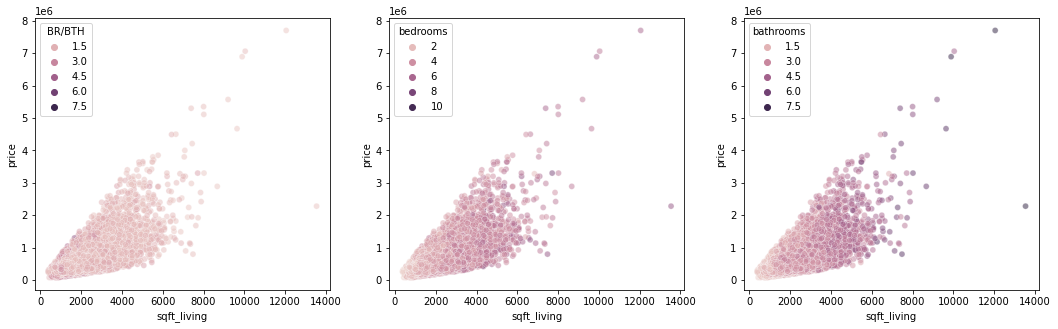

In [93]:
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
sns.scatterplot(hue = 'BR/BTH', y = 'price', x = 'sqft_living', data = df_ls,alpha=0.5, ax=axes[0])
sns.scatterplot(hue = 'bedrooms', y = 'price', x = 'sqft_living', data = df_ls,alpha=0.5, ax=axes[1])
sns.scatterplot(hue = 'bathrooms', y = 'price', x = 'sqft_living', data = df_ls,alpha=0.5, ax=axes[2])
ax.ticklabel_format(style='plain');

In [94]:
df_ls.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,BR/BTH
0,221900.0,3,1.0,1180,5650,1.0,1180,0,3.0
1,538000.0,3,2.25,2570,7242,2.0,2170,400,1.3333333333333333
2,180000.0,2,1.0,770,10000,1.0,770,0,2.0
3,604000.0,4,3.0,1960,5000,1.0,1050,910,1.3333333333333333
4,510000.0,3,2.0,1680,8080,1.0,1680,0,1.5


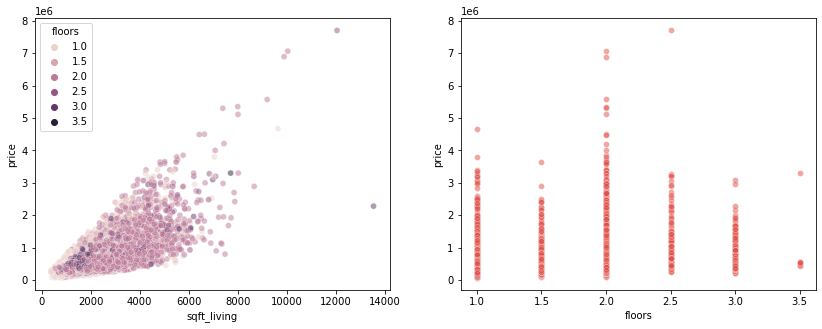

In [95]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
sns.scatterplot(hue = 'floors', y = 'price', x = 'sqft_living', data = df_ls,alpha=0.5, ax=axes[0])
sns.scatterplot(x = 'floors', y = 'price', data = df_ls,alpha=0.5, ax=axes[1])
ax.ticklabel_format(style='plain');

In [96]:
df_ls.floors.value_counts()

1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

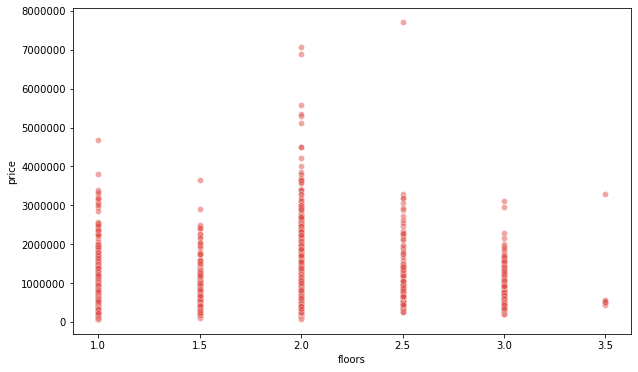

In [97]:
fig,ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x = 'floors', y = 'price', data = df_ls,alpha=0.5)
ax.ticklabel_format(style='plain');

Create new columns by combining

In [98]:
# FAR: Floor Area Ratio
df_ls['FAR'] = df_ls['sqft_living'] / df_ls['sqft_lot']

<ipython-input-98-321bbf913690>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ls['FAR'] = df_ls['sqft_living'] / df_ls['sqft_lot']


In [99]:
# attempt to calculate the yard
# suppose first floor area = (living-basement) / floors
# yard will be: lot - first floor

df_ls['yard'] = df_ls['sqft_lot'] - ((df_ls['sqft_living'] - df_ls['sqft_basement']) / df_ls['floors'])

<ipython-input-99-6c3a2c5936ef>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ls['yard'] = df_ls['sqft_lot'] - ((df_ls['sqft_living'] - df_ls['sqft_basement']) / df_ls['floors'])


In [100]:
df_ls

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,BR/BTH,FAR,yard
0,221900.0,3,1.0,1180,5650,1.0,1180,0,3.0,0.2088495575221239,4470.0
1,538000.0,3,2.25,2570,7242,2.0,2170,400,1.3333333333333333,0.3548743441038387,6157.0
2,180000.0,2,1.0,770,10000,1.0,770,0,2.0,0.077,9230.0
3,604000.0,4,3.0,1960,5000,1.0,1050,910,1.3333333333333333,0.392,3950.0
4,510000.0,3,2.0,1680,8080,1.0,1680,0,1.5,0.2079207920792079,6400.0
...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.5,1530,1131,3.0,1530,0,1.2,1.3527851458885942,621.0
21593,400000.0,4,2.5,2310,5813,2.0,2310,0,1.6,0.39738517116807154,4658.0
21594,402101.0,2,0.75,1020,1350,2.0,1020,0,2.6666666666666665,0.7555555555555555,840.0
21595,400000.0,3,2.5,1600,2388,2.0,1600,0,1.2,0.6700167504187605,1588.0


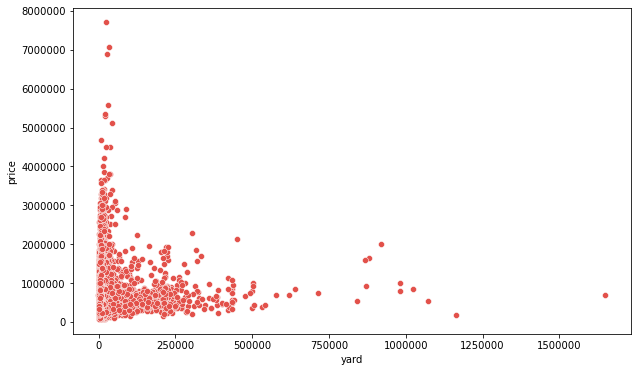

In [101]:
fig,ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x = 'yard', y = 'price', data = df_ls)
ax.ticklabel_format(style='plain');

In [102]:
# Living space / bedrooms
# higher means you have more space for other rooms
# such as kitchen, living room, game room, home gym
df_ls['Living_Space_VS_Bedroom'] = (df_ls['sqft_living'] - df_ls['sqft_basement'])/df_ls['bedrooms']

<ipython-input-102-17e96cc7dcf6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ls['Living_Space_VS_Bedroom'] = (df_ls['sqft_living'] - df_ls['sqft_basement'])/df_ls['bedrooms']


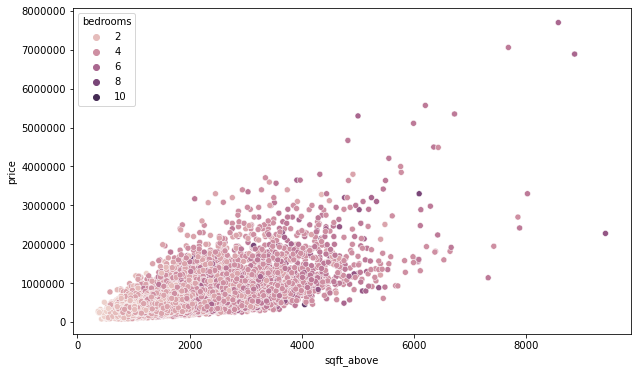

In [106]:
fig,ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x = 'sqft_above', y = 'price', hue = 'bedrooms', data = df_ls)
ax.ticklabel_format(style='plain');

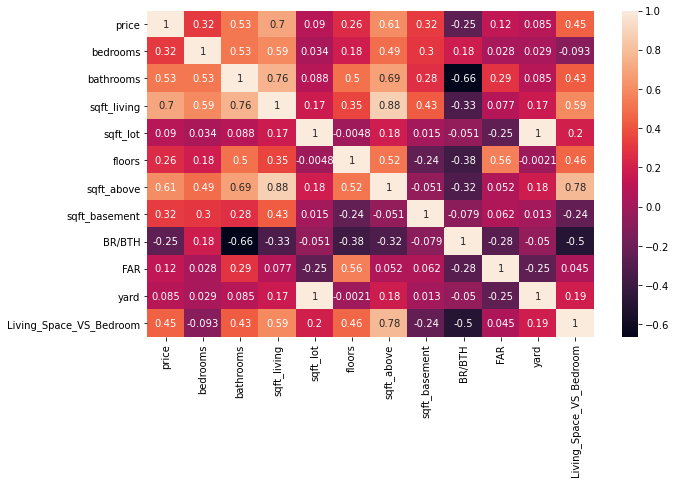

In [107]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_ls.corr(),annot=True);

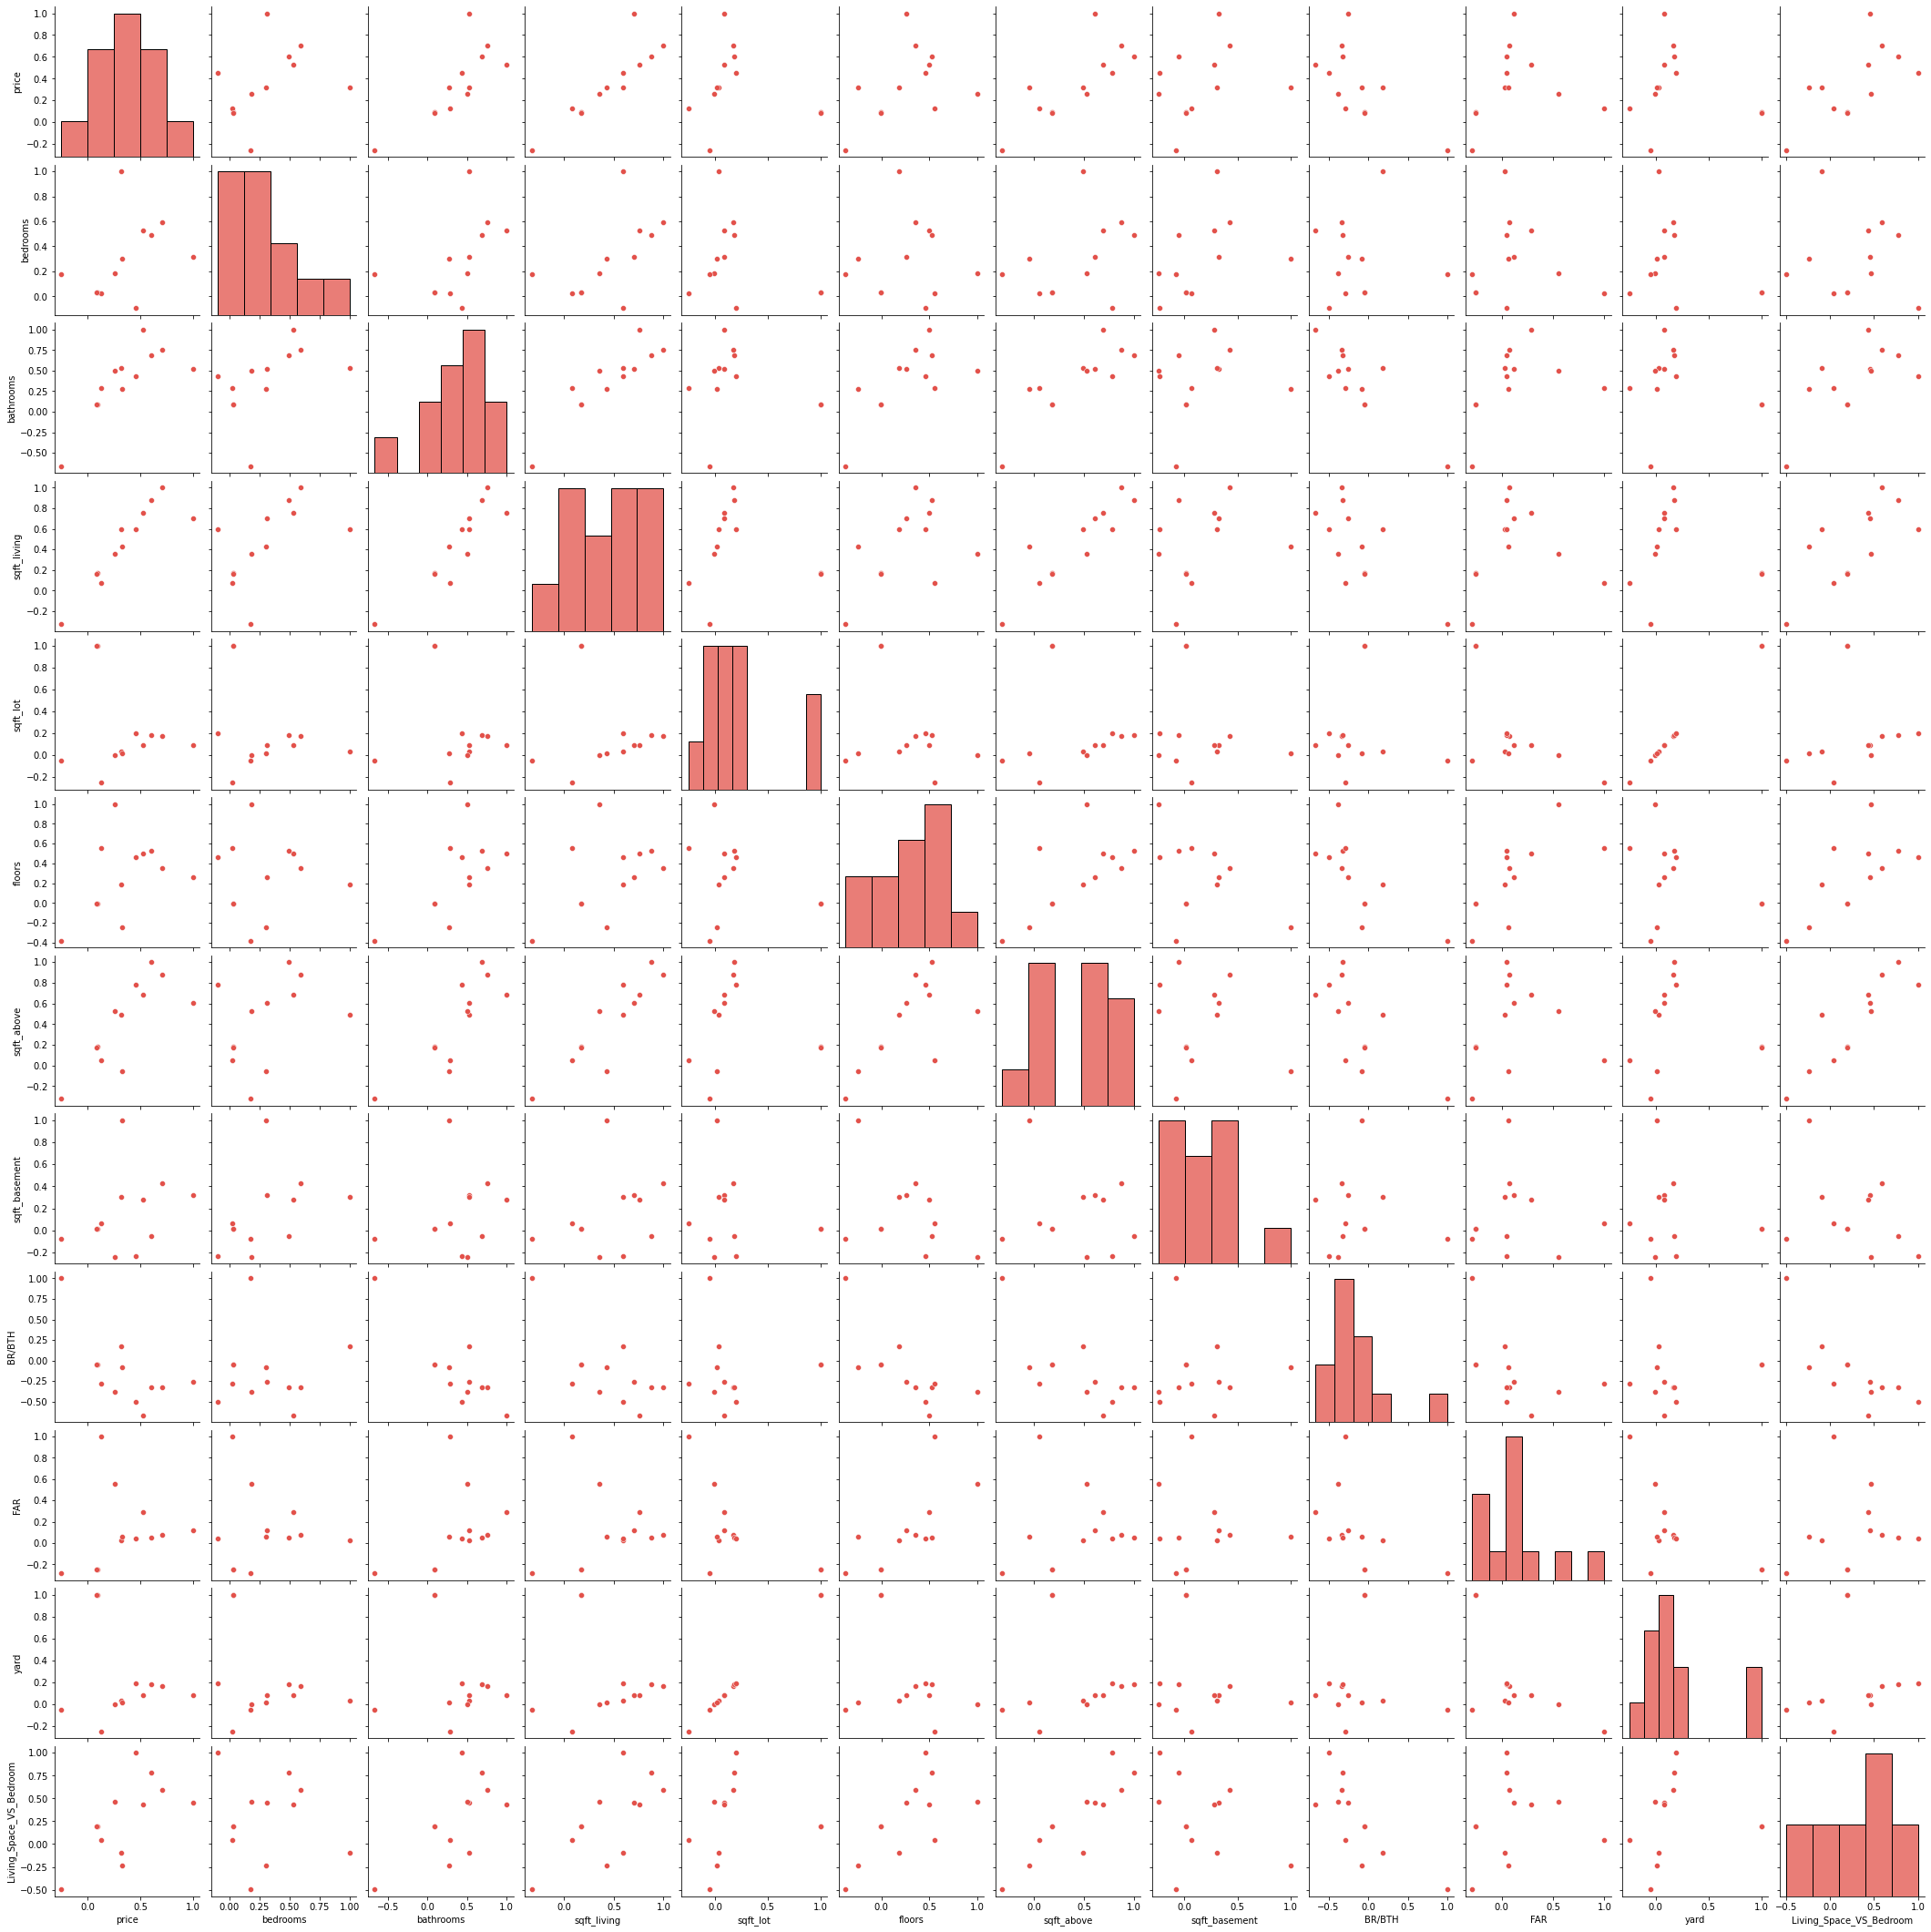

In [108]:
sns.pairplot(df_ls.corr());

## (test only) living space simple baseline model

In [34]:
col_selector = ['sqft_living','bedrooms','Living_Space_VS_Bedroom','sqft_lot', 'floors']
X_ls = df_ls[col_selector]
y = df_ls.price

In [35]:
X_ls_stand = X_ls.apply(lambda x: (x-x.mean()/x.std()))
y_stand = (y-y.mean())/y.std()

In [36]:
ls_simple_model = sm.OLS(y_stand,sm.add_constant(X_ls_stand)).fit()

In [38]:
print(ls_simple_model.summary()) # the team decided to use another baseline

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     4562.
Date:                Wed, 14 Sep 2022   Prob (F-statistic):               0.00
Time:                        11:41:27   Log-Likelihood:                -22858.
No. Observations:               21597   AIC:                         4.573e+04
Df Residuals:                   21591   BIC:                         4.578e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

## EDA HOUSE CONDITION

In [39]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [40]:
col_selector = ['price','grade','condition','yr_built', 'yr_renovated','sqft_living']
df_condition = df[col_selector]
df_condition.head()

,price,grade,condition,yr_built,yr_renovated,sqft_living
0,221900.0,7,2,1955,0.0,1180
1,538000.0,7,2,1951,1991.0,2570
2,180000.0,6,2,1933,0.0,770
3,604000.0,7,4,1965,0.0,1960
4,510000.0,8,2,1987,0.0,1680


<AxesSubplot:xlabel='condition', ylabel='price'>

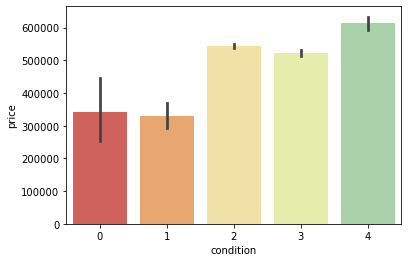

In [41]:
sns.barplot(x = 'condition', y = 'price', data = df_condition)

<AxesSubplot:xlabel='grade', ylabel='price'>

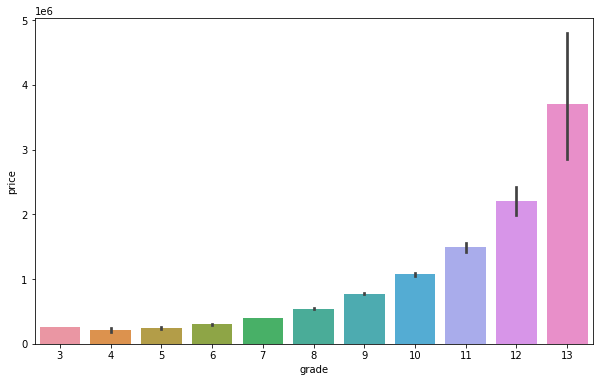

In [54]:
fig,ax = plt.subplots(figsize=(10,6))
sns.barplot(x = 'grade', y = 'price', data = df_condition,ax=ax)

In [55]:
df_condition["log_grade"] = df["grade"].apply(lambda x: np.log(x))

<ipython-input-55-29115db5be00>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_condition["log_grade"] = df["grade"].apply(lambda x: np.log(x))


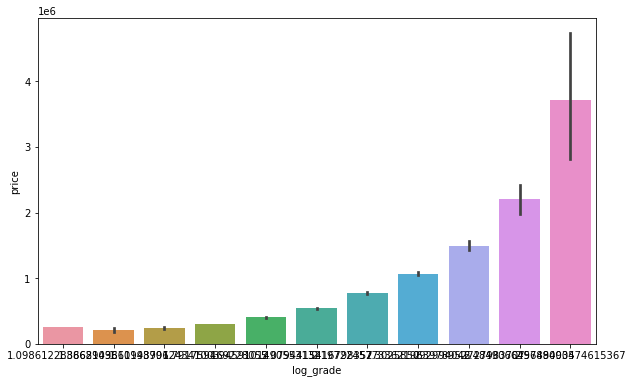

In [56]:
fig,ax = plt.subplots(figsize=(10,6))
sns.barplot(x = 'log_grade', y = 'price', data = df_condition);

In [57]:
df_condition.yr_built.value_counts().sort_index()

1900     87
1901     29
1902     27
1903     46
1904     45
       ... 
2011    130
2012    170
2013    201
2014    559
2015     38
Name: yr_built, Length: 116, dtype: int64

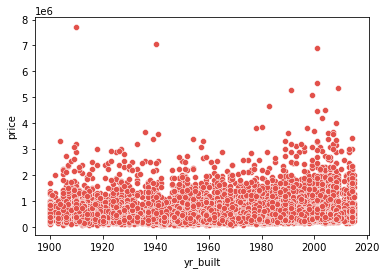

In [58]:
sns.scatterplot(x = 'yr_built', y = 'price', data = df_condition);
# can't tell much

In [59]:
bins = np.arange(1900,2030,10)
labels = np.arange(1,13,1)
df_condition['yr_built_pd'] = pd.cut(df_condition.yr_built, bins = bins, labels = labels,
       include_lowest=True)

<ipython-input-59-570a6d7b7d46>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_condition['yr_built_pd'] = pd.cut(df_condition.yr_built, bins = bins, labels = labels,


<AxesSubplot:xlabel='yr_built_pd', ylabel='price'>

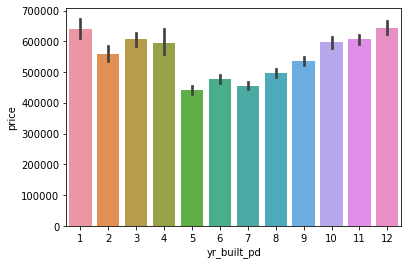

In [60]:
sns.barplot(x = 'yr_built_pd', y = 'price', data = df_condition)
# older house are more expensive
# maybe old house + renovated more expensive?

In [61]:
df_condition['renovated']= df_condition['yr_renovated'].apply(lambda x: 0 if x == 0.0 else 1)
# 1 means renovated, 0 means no
# assume renovated year doesn't matter

<ipython-input-61-8d08a4d84c18>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_condition['renovated']= df_condition['yr_renovated'].apply(lambda x: 0 if x == 0.0 else 1)


In [62]:
df_condition.renovated

0        0
1        1
2        0
3        0
4        0
        ..
21592    0
21593    0
21594    0
21595    0
21596    0
Name: renovated, Length: 21597, dtype: int64

<AxesSubplot:xlabel='renovated', ylabel='price'>

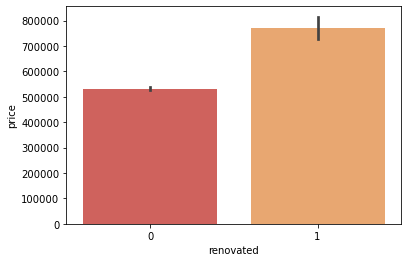

In [63]:
sns.barplot(x = 'renovated', y = 'price', data = df_condition)

how about range the yr renovated?

In [64]:
df.yr_renovated.value_counts().sort_index()

0.0       20853
1934.0        1
1940.0        2
1944.0        1
1945.0        3
          ...  
2011.0        9
2012.0        8
2013.0       31
2014.0       73
2015.0       14
Name: yr_renovated, Length: 70, dtype: int64

In [65]:
bins = [0, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]
labels = np.arange(1,11,1)
df_condition['yr_renovated_pd'] = pd.cut(df_condition.yr_renovated, bins = bins, labels = labels,
       include_lowest=True)

<ipython-input-65-8abea5cc995b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_condition['yr_renovated_pd'] = pd.cut(df_condition.yr_renovated, bins = bins, labels = labels,


<AxesSubplot:xlabel='yr_renovated_pd', ylabel='price'>

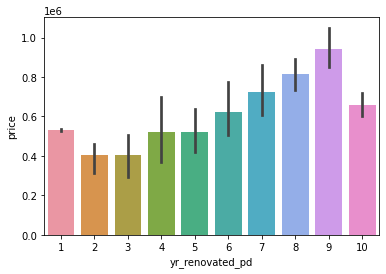

In [66]:
sns.barplot(x = 'yr_renovated_pd', y = 'price', data = df_condition)

how about yr_built + renovated?

In [67]:
bins = [0, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]
labels = np.arange(10,0,-1)
df_condition['renovated_recently_pd'] = pd.cut(df_condition.yr_renovated, bins = bins, labels = labels,
       include_lowest=True)

<ipython-input-67-a3930a818d23>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_condition['renovated_recently_pd'] = pd.cut(df_condition.yr_renovated, bins = bins, labels = labels,


In [68]:
df_condition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   price                  21597 non-null  float64 
 1   grade                  21597 non-null  int32   
 2   condition              21597 non-null  int8    
 3   yr_built               21597 non-null  int64   
 4   yr_renovated           21597 non-null  float64 
 5   sqft_living            21597 non-null  int64   
 6   log_grade              21597 non-null  float64 
 7   yr_built_pd            21597 non-null  category
 8   renovated              21597 non-null  int64   
 9   yr_renovated_pd        21597 non-null  category
 10  renovated_recently_pd  21597 non-null  category
dtypes: category(3), float64(3), int32(1), int64(3), int8(1)
memory usage: 1.2 MB


In [69]:
df_condition['yr_built_pd'] = df_condition['yr_built_pd'].astype(int)
df_condition['yr_renovated_pd'] = df_condition['yr_renovated_pd'].astype(int)
df_condition['renovated_recently_pd'] = df_condition['renovated_recently_pd'].astype(int)

<ipython-input-69-e3726f857272>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_condition['yr_built_pd'] = df_condition['yr_built_pd'].astype(int)
<ipython-input-69-e3726f857272>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_condition['yr_renovated_pd'] = df_condition['yr_renovated_pd'].astype(int)
<ipython-input-69-e3726f857272>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [70]:
df_condition['built_and_renovated'] = df_condition['yr_built_pd'] * df_condition['renovated_recently_pd']

<ipython-input-70-530e2a0d016b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_condition['built_and_renovated'] = df_condition['yr_built_pd'] * df_condition['renovated_recently_pd']


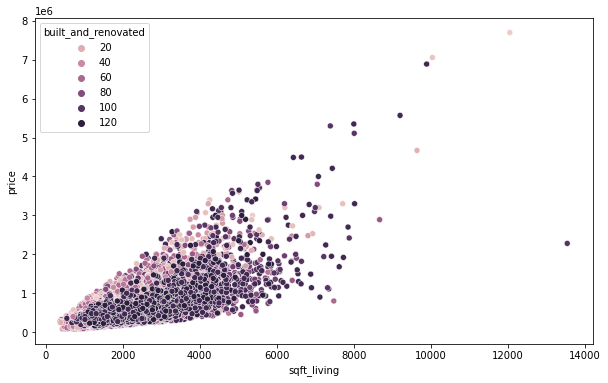

In [71]:
fig,ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x = 'sqft_living', y = 'price', hue = 'built_and_renovated', data = df_condition,ax=ax);

<AxesSubplot:>

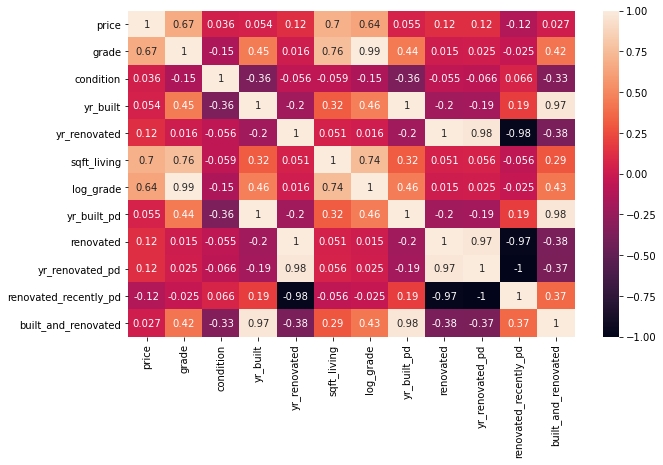

In [72]:
fig,ax = plt.subplots(figsize=(10,6))
sns.heatmap(df_condition.corr(),annot=True,ax=ax)

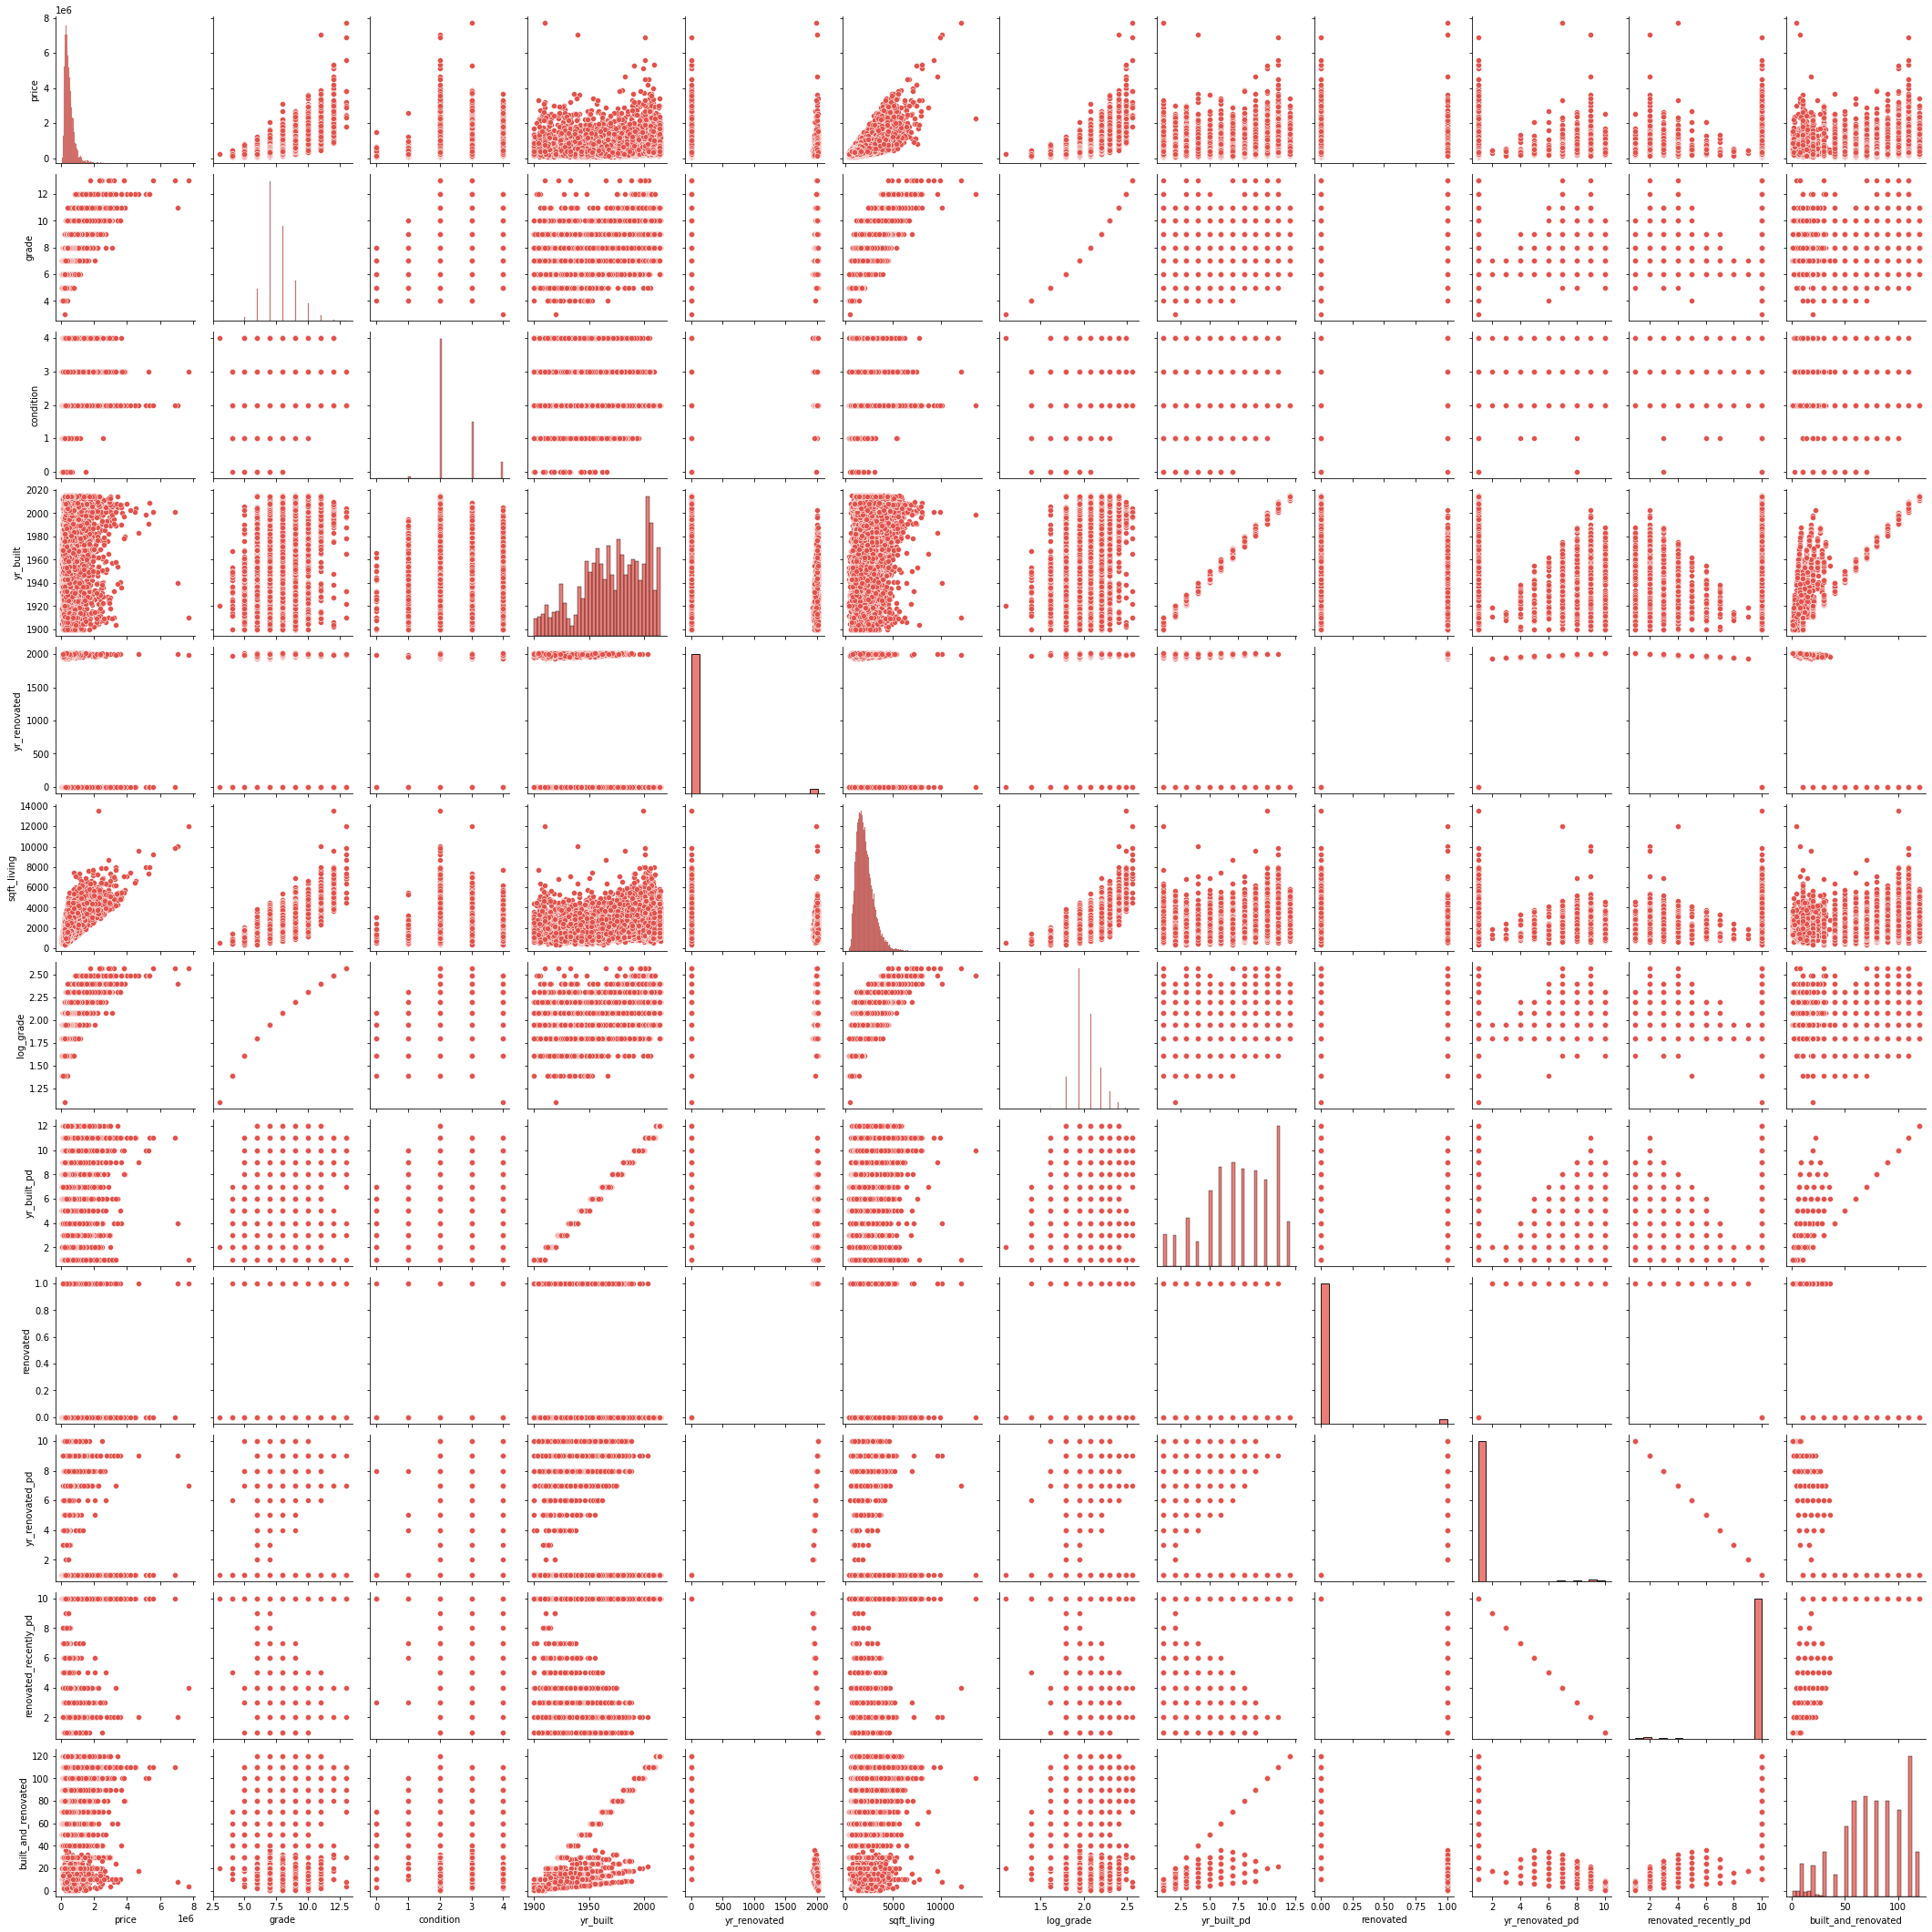

In [73]:
sns.pairplot(df_condition)

# OUTPUT! CSV AND CALL IT A DAY!

In [109]:
df.columns,df.shape

(Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
        'waterfront', 'view', 'condition', 'grade', 'sqft_above',
        'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
        'sqft_living15', 'sqft_lot15'],
       dtype='object'),
 (21597, 19))

In [112]:
col_selector = ['price','sqft_living','sqft_lot','sqft_above','bedrooms','bathrooms','floors','grade','condition','view','waterfront']
df_sel = df[col_selector]

In [113]:
df_condition.columns, df_condition.shape

(Index(['price', 'grade', 'condition', 'yr_built', 'yr_renovated',
        'sqft_living', 'log_grade', 'yr_built_pd', 'renovated',
        'yr_renovated_pd', 'renovated_recently_pd', 'built_and_renovated'],
       dtype='object'),
 (21597, 12))

In [115]:
col_selector = ['yr_built','yr_renovated','yr_built_pd','renovated','yr_renovated_pd','built_and_renovated']
df_condition_sel = df_condition[col_selector]

In [117]:
df_ls.columns, df_ls.shape

(Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
        'sqft_above', 'sqft_basement', 'BR/BTH', 'FAR', 'yard',
        'Living_Space_VS_Bedroom'],
       dtype='object'),
 (21597, 12))

In [119]:
col_selector = ['sqft_basement', 'BR/BTH', 'FAR', 'yard','Living_Space_VS_Bedroom']
df_ls_sel = df_ls[col_selector]

In [116]:
# df_loc.columns, df_loc.shape

(Index(['price', 'zipcode', 'sqft_living'], dtype='object'), (21597, 3))

In [120]:
df_sel.head(3)

,price,sqft_living,sqft_lot,sqft_above,bedrooms,bathrooms,floors,grade,condition,view,waterfront
0,221900.0,1180,5650,1180,3,1.0,1.0,7,2,0,0
1,538000.0,2570,7242,2170,3,2.25,2.0,7,2,0,0
2,180000.0,770,10000,770,2,1.0,1.0,6,2,0,0


In [121]:
df_ls_sel.head(3)

,sqft_basement,BR/BTH,FAR,yard,Living_Space_VS_Bedroom
0,0,3.0,0.2088495575221239,4470.0,393.3333333333333
1,400,1.3333333333333333,0.3548743441038387,6157.0,723.3333333333334
2,0,2.0,0.077,9230.0,385.0


In [123]:
df_output = pd.merge(df_sel,df_ls_sel, left_index=True, right_index=True)

In [124]:
df_output = pd.merge(df_output, df_condition_sel, left_index=True, right_index=True)

In [125]:
df_output

,price,sqft_living,sqft_lot,sqft_above,bedrooms,bathrooms,floors,grade,condition,view,...,BR/BTH,FAR,yard,Living_Space_VS_Bedroom,yr_built,yr_renovated,yr_built_pd,renovated,yr_renovated_pd,built_and_renovated
0,221900.0,1180,5650,1180,3,1.0,1.0,7,2,0,...,3.0,0.2088495575221239,4470.0,393.3333333333333,1955,0.0,6,0,1,60
1,538000.0,2570,7242,2170,3,2.25,2.0,7,2,0,...,1.3333333333333333,0.3548743441038387,6157.0,723.3333333333334,1951,1991.0,6,1,8,18
2,180000.0,770,10000,770,2,1.0,1.0,6,2,0,...,2.0,0.077,9230.0,385.0,1933,0.0,4,0,1,40
3,604000.0,1960,5000,1050,4,3.0,1.0,7,4,0,...,1.3333333333333333,0.392,3950.0,262.5,1965,0.0,7,0,1,70
4,510000.0,1680,8080,1680,3,2.0,1.0,8,2,0,...,1.5,0.2079207920792079,6400.0,560.0,1987,0.0,9,0,1,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,1530,1131,1530,3,2.5,3.0,8,2,0,...,1.2,1.3527851458885942,621.0,510.0,2009,0.0,11,0,1,110
21593,400000.0,2310,5813,2310,4,2.5,2.0,8,2,0,...,1.6,0.39738517116807154,4658.0,577.5,2014,0.0,12,0,1,120
21594,402101.0,1020,1350,1020,2,0.75,2.0,7,2,0,...,2.6666666666666665,0.7555555555555555,840.0,510.0,2009,0.0,11,0,1,110
21595,400000.0,1600,2388,1600,3,2.5,2.0,8,2,0,...,1.2,0.6700167504187605,1588.0,533.3333333333334,2004,0.0,11,0,1,110


In [126]:
df_output.to_csv(r'C:\Users\qwswe\Documents\Flatiron\DS_P2_King-County-House-Sales-Predict\Data_Han\df_for_model.csv', index = False)